# Autism Prediction in Adults Using Bayesian Networks

The dataset has been taken from https://www.kaggle.com/competitions/autismdiagnosis/

In [1]:
TRAIN_SET_PATH = "./dataset/train.csv"
TEST_SET_PATH = "./dataset/test.csv"
VALIDATION_SET_N_SAMPLES = 10

from itertools import combinations
import typing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator, BDeuScore, K2Score, BicScore, ExhaustiveSearch, PC, CITests, HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.independencies.Independencies import IndependenceAssertion
from pgmpy.inference import VariableElimination
from sklearn import metrics
from sklearn.model_selection import train_test_split

C:\Users\giorg\anaconda3\envs\FAIKR3_Project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_set = pd.read_csv(TRAIN_SET_PATH, index_col=0)
features_names = list(train_set.columns)
n_features = len(features_names)
n_samples = len(train_set)

print("The dataset has the following %d features:" % n_features)
print(", ".join(features_names), end="\n\n")
print("In total there are %d samples in the dataset." % n_samples)

The dataset has the following 21 features:
A1_Score, A2_Score, A3_Score, A4_Score, A5_Score, A6_Score, A7_Score, A8_Score, A9_Score, A10_Score, age, gender, ethnicity, jaundice, austim, contry_of_res, used_app_before, result, age_desc, relation, Class/ASD

In total there are 800 samples in the dataset.


In [3]:
# Rename the features for better readability

train_set.rename(columns = {'age':'Age', 'gender': 'Gender', 'ethnicity': 'Ethnicity', 'jaundice': 'Jaundice', 'austim':'Autism', 
                            'contry_of_res': 'Country_of_Res', 'used_app_before': 'Used_App_Before', 'result': 'Result', 'age_desc': 'Age_Desc', 'relation': 'Relation'}, inplace = True)

## Description of the dataset's features

* ID
    + It's the ID of the patient, loaded as index of the dataframe
    
* A1_Score to A10_Score
    + Score based on Autism Spectrum Quotient (AQ) 10 item screening tool.
    + This screening tool makes use of a list of 10 questions, such as "I often notice small sounds when others do not", or "I know how to tell if someone listening to me is getting bored", to which the subject can answer one of the following:
        1. Definitely Agree
        2. Slightly Agree
        3. Slightly Disagree
        4. Definitely Disagree
    + A single point is assigned to the questions 1, 7, 8, and 10 if the answer is either "Definitely Agree" or "Slightly Agree". For the remaining questions, a single point is assigned if the answer is either "Definitely Disagree" or "Slightly Disagree". Therefore these features are binary.
    + This test shall never be considered conclusive, and in general whenever the subject scores 6 or more points it is an indication of a possible disorder falling in the spectrum of autism.

* Age
    + The age of the patient in years.
    + This is a continuous numerical feature, which could be modeled by some continuous probability distribution. In order to better handle it in pgmpy I'm going to discretize it.

* Gender
    + The gender of the patient.
    + Categorical binary variable: either "f" or "m".

* Ethnicity
    + Ethnicity of the patient.
    + Cathegorical variable, examples of ethnicity are "White-European" or "Middle Eastern".

* Jaundice
    + Whether the patient had jaundice, which are sometimes associated with autism, at the time of the birth.
    + Categorical binary variable: either "yes" or "no".
    
* Autism
    + Whether an immediate family member has been diagnosed with autism, which can have genetic bases.
    + Categorical binary variable: either "yes" or "no".

* Country_of_res
    + Country of residence of the patient.
    + Not sure about the potential predictive role of this feature, it seems unrealistic to have a correlation between living in a certain country and having an autistic disorder. In addition, provided there was any correlation, if the dataset is not perfectly balanced considering such variable would be completely detrimental. Further analysis is needed to decide whether to include it or not.
    + Categorical variable.
    
* Used_app_before
    + Whether the patient has undergone a screening test before.
    + Potentially having took a screening test before could influence the output of the following tests. In addition, it could be an indicator of potential pre-exsisting worries of the patient or of its parents. I will analyze how this features correlates with the target variable to get better insights.
    + Categorical binary variable: either "yes" or "no".

* Result
    + Score for the AQ1-10 screening test.
    + It is a continuous numerical attribute, therefore it should be discretized.
    + Not sure about how the score was computed, since it is not stated anywhere. In addition, since it is derived from other variables it could be not worth to include it. For these reason it will not be considered.

* Relation
    + Relation of patient who completed the test.
    + Potentially the test could be completed by one relative of the patient, like his/her father or mother.
    + It is a categorical variable, which assumes values like "Self" or "Relative".

* Age_desc
    + Description in words of patient's age.
    + This is a useless attributes and therefore it will be removed.

* Class/ASD
    + Classified result as 0 or 1. 0 represents no autism.
    + This is the target variable we are interested in.

## Data Cleaning & Data Analysis

* Discretization of the continuous variables
* Sanitization of nominal variables (inpection of the possible values to see if there is any repetition due to typos for example)
* Mapping of nominal variables to numeric for correlation computation (the same mapping has to be applied to the test set at inference time)
* Analysis of the features' distribution and correlation wrt the class, to determine whether to keep them or not.

In [4]:
# Here I chose the bins by searching for relevant intervals of age in the literature.

age_bins = [0, 6, 11, 14, 19, 25, 44, 65, np.inf]
age_labels = ['First/Second-Infancy', 'Third-Infancy', 'Pre-Adolescent', 'Adolescent', 'Young Adult', 'Adult', 'Middle-Age', 'Senility']
train_set['Age'] = pd.cut(train_set['Age'], bins=age_bins, labels=age_labels, right=False)

age_map = {
    age_label: i for i, age_label in enumerate(age_labels)
}

In [5]:
print("The possible values for Used_App_Before are: ", ", ".join(train_set.Used_App_Before.unique()))
print("The possible values for Gender are: ", ", ".join(train_set.Gender.unique()))
print("The possible values for Jaundice are: ", ", ".join(train_set.Jaundice.unique()))
print("The possible values for Autism are: ", ", ".join(train_set.Autism.unique()))
print("The possible values for Relation are: ", ", ".join(train_set.Relation.unique()))

The possible values for Used_App_Before are:  no, yes
The possible values for Gender are:  f, m
The possible values for Jaundice are:  no, yes
The possible values for Autism are:  no, yes
The possible values for Relation are:  Self, Relative, Parent, ?, Others, Health care professional


In [6]:
# ? to Unkwnown just for better readability (even though it is going eventually to be turned into an integer)
train_set["Relation"] = train_set["Relation"].str.replace("?", "Unknown", regex=False)

no_yes_map = {
    'no': 0,
    'yes': 1
}

gender_map = {
    'f': 0,
    'm': 1
}

relation_map = {
    'Self': 0,
    'Relative': 1,
    'Parent': 2,
    'Unknown': 3,
    'Others': 4,
    'Health care professional': 5
}

train_set['Used_App_Before'] = train_set['Used_App_Before'].map(no_yes_map)
train_set['Gender'] = train_set['Gender'].map(gender_map)
train_set['Jaundice'] = train_set['Jaundice'].map(no_yes_map)
train_set['Autism'] = train_set['Autism'].map(no_yes_map)
train_set['Relation'] = train_set['Relation'].map(relation_map)
train_set['Age'] = train_set['Age'].map(age_map).astype(int)

In [7]:
possible_countries_train = train_set.Country_of_Res.unique()
print("The possible countries of residence found in the train set are: ", ", ".join(possible_countries_train))

The possible countries of residence found in the train set are:  Austria, India, United States, South Africa, Jordan, United Kingdom, Brazil, New Zealand, Canada, Kazakhstan, United Arab Emirates, Australia, Ukraine, Iraq, France, Malaysia, Viet Nam, Egypt, Netherlands, Afghanistan, Oman, Italy, AmericanSamoa, Bahamas, Saudi Arabia, Ireland, Aruba, Sri Lanka, Russia, Bolivia, Azerbaijan, Armenia, Serbia, Ethiopia, Sweden, Iceland, Hong Kong, Angola, China, Germany, Spain, Tonga, Pakistan, Iran, Argentina, Japan, Mexico, Nicaragua, Sierra Leone, Czech Republic, Niger, Romania, Cyprus, Belgium, Burundi, Bangladesh


<AxesSubplot:title={'center':'Number of autistic patients vs total number of patients per country'}, xlabel='Country of residence', ylabel='Number of patients'>

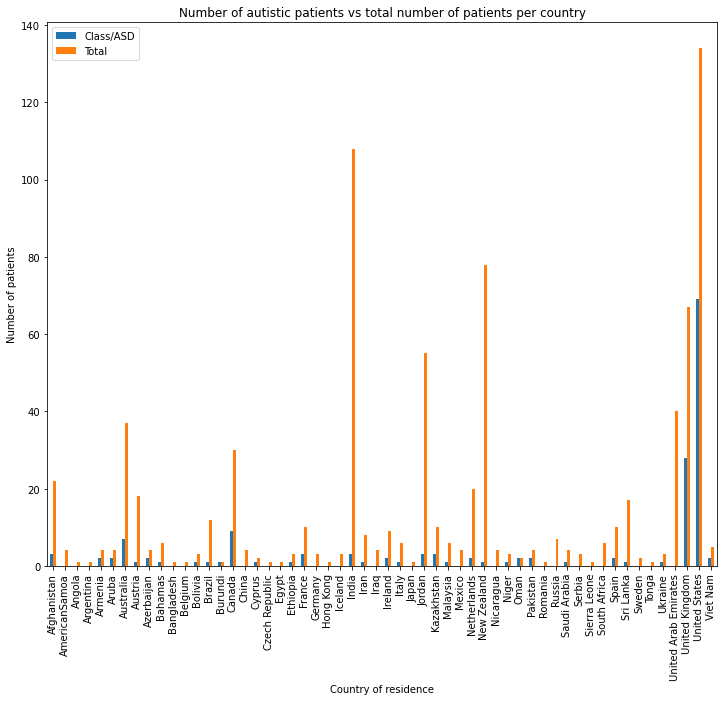

In [8]:
train_set["Total"] = [1] * len(train_set)
country_of_res_bar_plot = train_set.groupby("Country_of_Res")[["Class/ASD", "Total"]].sum()
country_of_res_bar_plot.plot(kind='bar', title='Number of autistic patients vs total number of patients per country', ylabel='Number of patients', xlabel='Country of residence', figsize=(12, 10))

In [9]:
print("The possible ethnicities found in the train set are: ", ", ".join(train_set.Ethnicity.unique()))

The possible ethnicities found in the train set are:  ?, White-European, Middle Eastern , Pasifika, Black, Others, Hispanic, Asian, Turkish, South Asian, Latino, others


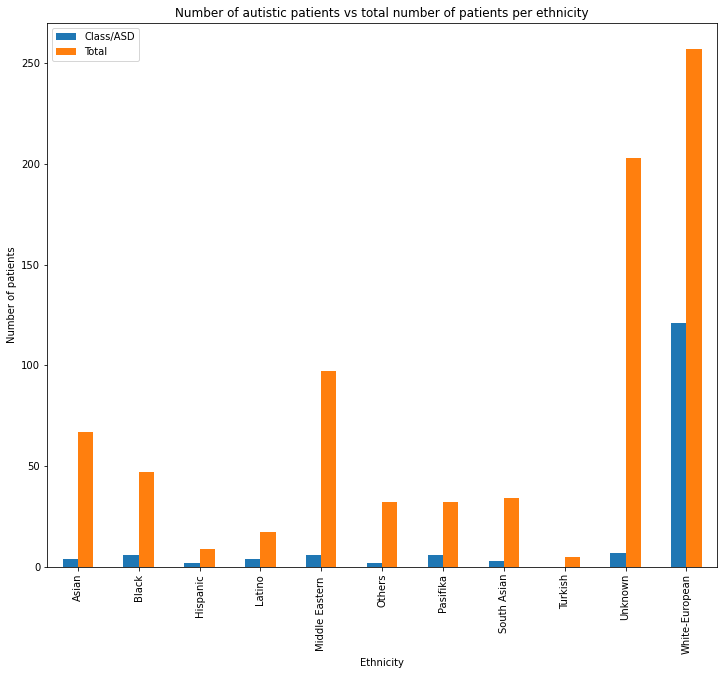

In [10]:
# ? stands for unknown ethnicity, while Others and others being actually the same can be incorporated
train_set["Ethnicity"] = train_set["Ethnicity"].str.replace("?", "Unknown", regex=False).replace("others", "Others", regex=False)

country_of_res_bar_plot = train_set.groupby("Ethnicity")[["Class/ASD", "Total"]].sum()
country_of_res_bar_plot.plot(kind='bar', title='Number of autistic patients vs total number of patients per ethnicity', ylabel='Number of patients', xlabel='Ethnicity', figsize=(12, 10))
train_set.drop("Total", inplace=True, axis=1)

In [11]:
country_of_res_map = {
    country: i for i, country in enumerate(train_set["Country_of_Res"].unique())
}

ethnicity_map = {
    ethnicity: i for i, ethnicity in enumerate(train_set["Ethnicity"].unique())
}

train_set['Country_of_Res'] = train_set['Country_of_Res'].map(country_of_res_map).astype(int)
train_set['Ethnicity'] = train_set['Ethnicity'].map(ethnicity_map).astype(int)

In [12]:
train_set.corr()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,Age,Gender,Ethnicity,Jaundice,Autism,Country_of_Res,Used_App_Before,Result,Relation,Class/ASD
A1_Score,1.000000,0.401419,0.493016,0.383718,0.432912,0.371917,0.447262,0.191815,0.439397,0.390478,0.043710,-0.094794,-0.050730,0.127812,0.262947,0.050515,0.031209,0.307919,-0.065171,0.300474
A2_Score,0.401419,1.000000,0.489330,0.488173,0.427895,0.447721,0.452713,0.302040,0.511547,0.454422,0.056571,-0.047139,-0.134168,0.160084,0.315189,0.013966,0.077599,0.339144,-0.060400,0.372740
A3_Score,0.493016,0.489330,1.000000,0.558896,0.579769,0.511669,0.559118,0.315882,0.597022,0.510276,0.108878,-0.061107,-0.129434,0.183246,0.366994,0.004096,0.057090,0.428870,-0.119505,0.460927
A4_Score,0.383718,0.488173,0.558896,1.000000,0.559748,0.563543,0.554838,0.360781,0.576723,0.506292,0.086205,-0.005097,-0.087195,0.223980,0.395126,0.003407,0.065503,0.418214,-0.115968,0.501046
A5_Score,0.432912,0.427895,0.579769,0.559748,1.000000,0.494944,0.550663,0.292747,0.524624,0.436010,0.064190,-0.045153,-0.144251,0.181482,0.395629,0.003382,0.044895,0.369226,-0.100120,0.461773
A6_Score,0.371917,0.447721,0.511669,0.563543,0.494944,1.000000,0.496588,0.333694,0.536666,0.419172,0.035440,-0.028670,-0.129422,0.192151,0.390835,-0.052272,0.031582,0.411550,-0.104648,0.543010
A7_Score,0.447262,0.452713,0.559118,0.554838,0.550663,0.496588,1.000000,0.271903,0.539433,0.455326,0.060639,-0.063065,-0.085178,0.184542,0.392940,0.007678,0.032975,0.401655,-0.089021,0.452338
A8_Score,0.191815,0.302040,0.315882,0.360781,0.292747,0.333694,0.271903,1.000000,0.352747,0.250438,0.031349,-0.035098,-0.027795,0.100110,0.211854,-0.065007,0.067788,0.277795,-0.036865,0.312388
A9_Score,0.439397,0.511547,0.597022,0.576723,0.524624,0.536666,0.539433,0.352747,1.000000,0.485983,0.111907,-0.044149,-0.109046,0.156691,0.359126,-0.005055,0.043896,0.377139,-0.096030,0.463347
A10_Score,0.390478,0.454422,0.510276,0.506292,0.436010,0.419172,0.455326,0.250438,0.485983,1.000000,0.089616,-0.077647,-0.071421,0.163256,0.313520,0.035966,0.054456,0.333650,-0.029209,0.343736


### Discarded Features

Country_of_Res is discarded because its correlation with the target does realistically not entail causation. This can be understood both by reasoning about the meaning such a causal relationship would have, and by looking at the correlation plot. What could happen is that in certain industrialized countries much more attention is paid to disorders of the autistic spectrum, so in comparison a person with the same disorder but living in a poor country could have a much lower probability of being actually diagnosed with autism.
This is definitely something we want to avoid for several reasons, as algorithmic fairness.
Another problem is with dimensionality. Country_Of_Res takes many possible values, this means that to correctly estimate its CPT we would need many representative samples, which we don't have, as it can be noticed by looking at the bar plot.

Ethnicity has a causal relationship with the autistic disorders, subject of study in the literature:
"Maternal race/ethnicity and nativity are associated with offspring’s AD diagnosis and severity." - Becerra, Tracy A et al. “Autism spectrum disorders and race, ethnicity, and nativity: a population-based study.” Pediatrics vol. 134,1 (2014): e63-71. doi:10.1542/peds.2013-3928

For this reason, I decided to consider it, even though it does not show significative correlation with the target variable. In addition, the dataset is not balanced, as we have no case of autism for example associated with turkish ethnicity. When observed data is not representative for the underlying distribution, maximum likelihood estimations are not robust. 
For this reason approaches as bayesian estimation shall be used. In particular I decided to use bayesian estimation with bayesian dirichlet equivalent uniform prior (BDeu).

Gender is discarded because it has no role in autism, and does not indeed exhibit correlation with the class.
Age_Desc is discarded because it is completely useless once Age is discretized.
Result is discarded because it is derived from the 10 scores, in an unclear (probably not linear) way. In addition, it should be discretized, and since I do not posses the proper domain knowledge, it would be difficult to identify correct, meaningful, intervals.

In [13]:
train_set.drop(labels=["Gender", "Country_of_Res", "Age_Desc", "Result"], axis=1, inplace=True)

### Splitting the dataset into training and validation set

In [14]:
# Obtain a perfectly balanced validation set of 10 random items from the training set (5 positive, 5 negative)

positive_class_indices = train_set[train_set['Class/ASD'] == 1].index - 1
negative_class_indices = train_set[train_set['Class/ASD'] == 0].index - 1

test_set_indexes = np.concatenate([np.random.choice(positive_class_indices, size=VALIDATION_SET_N_SAMPLES, replace=False), np.random.choice(negative_class_indices, size=VALIDATION_SET_N_SAMPLES, replace=False)], axis=0)
train_set_indexes = np.delete(train_set.index - 1, test_set_indexes)

validation_set = train_set.iloc[test_set_indexes,:].copy()
train_set = train_set.iloc[train_set_indexes,:]


# Another method could be performing stratified sampling without raplecement to obtain a validation set with the same distribution (wrt the target class) as the training set

# train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=42, shuffle=True, stratify=train_set['Class/ASD'])

# Learning the Structure of the Bayesian Network

There are different options when it comes to structure the bayesian network:

* Taking a decision driven by problem domain knowledge.
    - There are different advantages with this approach: it often eventually leads to better explainable, simpler, models, different ideas regarding the structure can be compared based on several metrics (BIC or MDL, BDeu, AIC, K2, ...), independence assumptions can actually be tested based on data at our disposal, through the chi2 conditional independence tests for example.
* Algorithmically learning the structure 
    - This method is better suited when dealing with small networks, and when no domain knowledge is available. It is about search in the structures' space, comparing candidates based on the aforementioned metrics. The search can be exhaustive or not. Exhausive search becomes soon intractable as the number of nodes grows (the growth is exponential). The number of possible structures is the number of directed acyclic digraphs with n labeled nodes. For example for 2, 3, 4, 5, or 6 nodes, these are the possible number of DAGs: 3, 25, 543, 29281, 3781503. Heuristic search reduces the search space adopting a greedy approach, in which the structure is incrementally built. An example of such approaches is Hill Climbing, which can be enhanced adding a tabu list or enforcing some connection. Another option is constraint-based structure learning, in which first independeces are identified by conditional independence tests, and then the DAG is constructed according to tests' results. 
* Hybrid structure learning
    - This approach combines HillSearch with constraint-based structure learning, where the latter approach is used to construct the skeleton of the network, and the former is used to orient the edges in the DAG.
    - Another option would be to combine domain knowledge with heuristic approaches.

## Domain Knowledge-Driven Approach

Here I propose two possible structures of bayesian network, I test conditional independeces, and I compare them based on different metrics. Eventually the predictive power of these two models will be tested on a private test set directly on Kaggle.

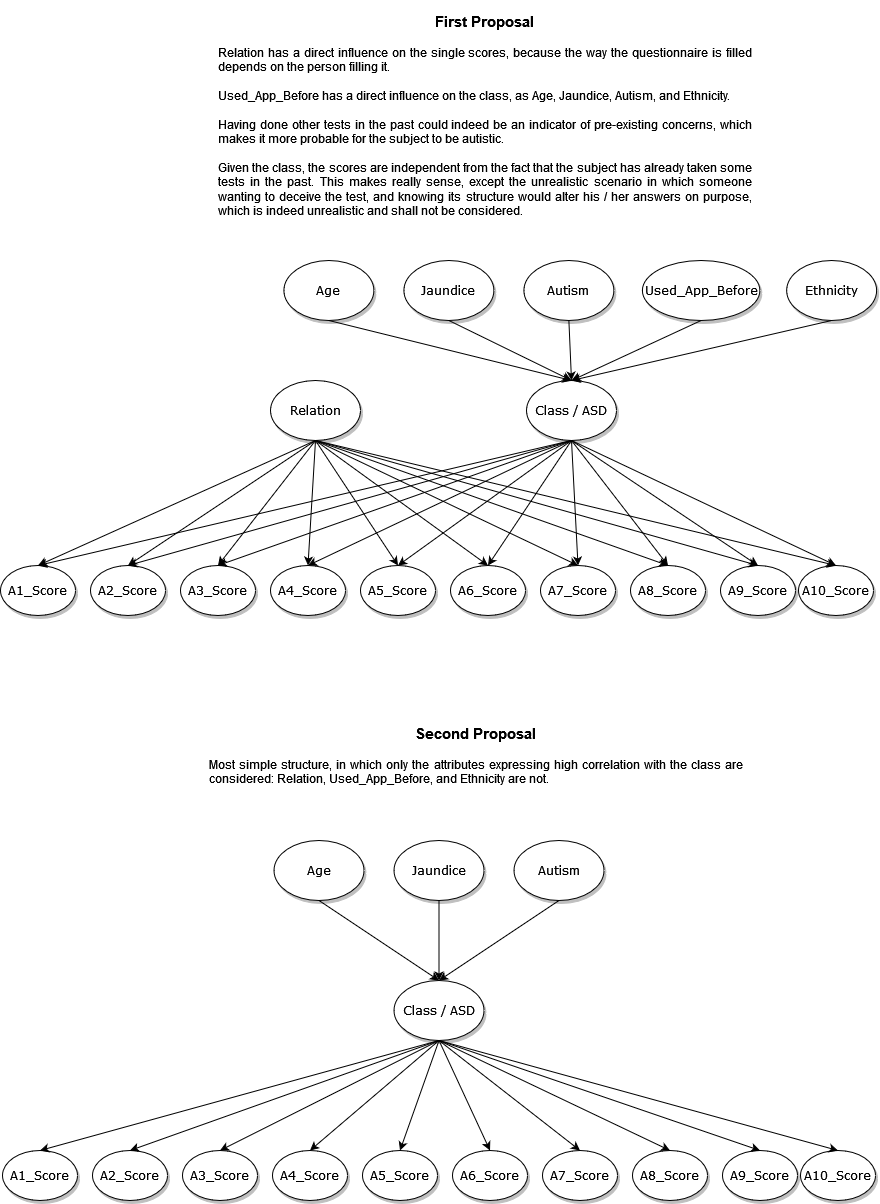

In [15]:
model_A_edges = [
    ('Age','Class/ASD'),
    ('Jaundice','Class/ASD'),
    ('Autism', 'Class/ASD'),
    ('Used_App_Before', 'Class/ASD'),
    ('Ethnicity', 'Class/ASD'),
    ('Relation', 'A1_Score'),
    ('Relation', 'A2_Score'),
    ('Relation', 'A3_Score'),
    ('Relation', 'A4_Score'),
    ('Relation', 'A5_Score'),
    ('Relation', 'A6_Score'),
    ('Relation', 'A7_Score'),
    ('Relation', 'A8_Score'),
    ('Relation', 'A9_Score'),
    ('Relation', 'A10_Score'),
    ('Class/ASD', 'A1_Score'),
    ('Class/ASD', 'A2_Score'),
    ('Class/ASD', 'A3_Score'),
    ('Class/ASD', 'A4_Score'),
    ('Class/ASD', 'A5_Score'),
    ('Class/ASD', 'A6_Score'),
    ('Class/ASD', 'A7_Score'),
    ('Class/ASD', 'A8_Score'),
    ('Class/ASD', 'A9_Score'),
    ('Class/ASD', 'A10_Score'),
]
model_A_nodes = ['Age', 'Jaundice', 'Autism', 'Relation', 'Used_App_Before', 'Ethnicity', 'Class/ASD', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score'] 
model_A = BayesianNetwork(model_A_edges)


model_B_nodes = ['Age', 'Jaundice', 'Autism', 'Class/ASD', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
model_B_edges = [
    ('Age','Class/ASD'),
    ('Jaundice','Class/ASD'),
    ('Autism', 'Class/ASD'),
    ('Class/ASD', 'A1_Score'),
    ('Class/ASD', 'A2_Score'),
    ('Class/ASD', 'A3_Score'),
    ('Class/ASD', 'A4_Score'),
    ('Class/ASD', 'A5_Score'),
    ('Class/ASD', 'A6_Score'),
    ('Class/ASD', 'A7_Score'),
    ('Class/ASD', 'A8_Score'),
    ('Class/ASD', 'A9_Score'),
    ('Class/ASD', 'A10_Score'),
]
model_B = BayesianNetwork(model_B_edges)

### Structure based scoring

The scores used are the BIC (equivalent of the MDL), the K2, and the BDeu.

In [16]:
bdeu = BDeuScore(train_set, equivalent_sample_size=10)
k2 = K2Score(train_set)
bic = BicScore(train_set)

def bayesian_network_structure_scoring(data: pd.DataFrame, model: BayesianNetwork, bdeu_eq_sample_size: int, model_name: str):
    bdeu = BDeuScore(data, equivalent_sample_size=bdeu_eq_sample_size)
    k2 = K2Score(data)
    bic = BicScore(data)
    print("_" * 10, model_name, "_" * 10, end="\n\n")
    print("BIC score: %.2f" % bic.score(model))
    print("K2 score: %.2f" % k2.score(model))
    print("BDeu score: %.2f" % bdeu.score(model))
    print("_" * (20 + len(model_name)), end="\n\n")


bayesian_network_structure_scoring(train_set[model_A_nodes], model_A, 10, "Model A")
bayesian_network_structure_scoring(train_set[model_B_nodes], model_B, 10, "Model B")

__________ Model A __________

BIC score: -11661.01
K2 score: -9261.49
BDeu score: -9408.06
___________________________

__________ Model B __________

BIC score: -7196.90
K2 score: -7121.47
BDeu score: -7150.00
___________________________



### Considerations

Model B scores better, which could indicate that actually it is better not to Relation, Used_App_Before, and Ethnicity, simplifying the structure.

### Conditional Independence Tests

In [17]:
for y in ["Age", "Jaundice", "Autism", "Ethnicity", "Used_App_Before"]:
    for i in range(1, 11):
        independent = CITests.chi_square(X='A{idx}_Score'.format(idx=i), Y=y, Z=['Class/ASD'], data=train_set, boolean=True, significance_level=0.05)
        if independent:
            print('A{idx}_Score is independent from {y} given Class/ASD'.format(idx=i, y=y))
        else:
            print('A{idx}_Score is NOT independent from {y} given Class/ASD'.format(idx=i, y=y))
    print()
    
for comb in combinations(["Age", "Jaundice", "Autism", "Ethnicity", "Used_App_Before"], 2):
    independent = CITests.chi_square(X=comb[0], Y=comb[1], Z=[], data=train_set, boolean=True, significance_level=0.05)
    if independent:
        print("{A} and {B} are independent".format(A=comb[0], B=comb[1]))
    else:
        print("{A} and {B} are NOT independent".format(A=comb[0], B=comb[1]))
    
    independent = CITests.chi_square(X=comb[0], Y=comb[1], Z=["Class/ASD"], data=train_set, boolean=True, significance_level=0.05)
    if independent:
        print("{A} and {B} are independent given Class/ASD".format(A=comb[0], B=comb[1]))
    else:
        print("{A} and {B} are NOT independent given Class/ASD".format(A=comb[0], B=comb[1]))

print()

if CITests.chi_square(X="Relation", Y="Class/ASD", Z=[], data=train_set, boolean=True, significance_level=0.05):
    print("Relation is independent from Class/ASD")
else:
    print("Relation is NOT independent from Class/ASD")

print()

for i in range(1, 11):
    independent = CITests.chi_square(X='Relation', Y='A{idx}_Score'.format(idx=i), Z=[], data=train_set, boolean=True, significance_level=0.05)
    if independent:
        print('A{idx}_Score is independent from Relation'.format(idx=i))
    else:
        print('A{idx}_Score is NOT independent from Relation'.format(idx=i))

A1_Score is independent from Age given Class/ASD
A2_Score is independent from Age given Class/ASD
A3_Score is independent from Age given Class/ASD
A4_Score is independent from Age given Class/ASD
A5_Score is independent from Age given Class/ASD
A6_Score is independent from Age given Class/ASD
A7_Score is independent from Age given Class/ASD
A8_Score is independent from Age given Class/ASD
A9_Score is independent from Age given Class/ASD
A10_Score is independent from Age given Class/ASD

A1_Score is NOT independent from Jaundice given Class/ASD
A2_Score is NOT independent from Jaundice given Class/ASD
A3_Score is NOT independent from Jaundice given Class/ASD
A4_Score is NOT independent from Jaundice given Class/ASD
A5_Score is NOT independent from Jaundice given Class/ASD
A6_Score is NOT independent from Jaundice given Class/ASD
A7_Score is NOT independent from Jaundice given Class/ASD
A8_Score is independent from Jaundice given Class/ASD
A9_Score is NOT independent from Jaundice given 

### Considerations

The structures I proposed are mostly supported by the conditional independence tests, with some exception which shall be commented.
For example while Jaundice and Autism are not independent by themselves, they are when conditioned on Class/ASD, as it was expected, because a jaundice at birth is associated with a relative having autism only when the child has autism, except for rare coincidences.
In contrast, Autism and Ethnicity are not independent, even when conditioned on Class/ASD. An explanation for this is simply that since ethnicity has a role in autism then it is more probable to have a relative with autism when you are in certain countries, irregardless of whether you are an autistic patient or not.

This kind of tests can give us really valuable insight on the task, making us better understand the nature of the problem and the relationship between the variables.

Another extremely interesting example is that the scores are unexpectedly NOT independent from Autism, Ethnicity and Jaundice given Class/ASD. This can be explained as it follows:
* Ethnicity has a role on personality, influencing the way these question are answered, irregardless of wheter the subject has an ASD or not.
* Jaundice can have a relationship with other personality disorders, not necessarly following in the autistic spectrum, and this in turn can influence the answer to the questions.
* A close relative (like a parent, which is often the case) having an ASD can influence your personality, determining an impact on the way you answer the question, or has for jaundice it could be related to other personality disorders (for genetic factors).

### Bayesian Parameters Estimation

In [18]:
model_A.fit(data=train_set[model_A_nodes], 
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10)

model_B.fit(data=train_set[model_B_nodes], 
            estimator=BayesianEstimator,
            prior_type="BDeu",
            equivalent_sample_size=10)

In [19]:
print("CPTs of Model A")
print()

for cpd in model_A.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

CPTs of Model A

CPT of Age:
+--------+-----------+
| Age(0) | 0.0155063 |
+--------+-----------+
| Age(1) | 0.0889241 |
+--------+-----------+
| Age(2) | 0.0648734 |
+--------+-----------+
| Age(3) | 0.153481  |
+--------+-----------+
| Age(4) | 0.185127  |
+--------+-----------+
| Age(5) | 0.325633  |
+--------+-----------+
| Age(6) | 0.124367  |
+--------+-----------+
| Age(7) | 0.0420886 |
+--------+-----------+ 

CPT of Class/ASD:
+-----------------+-----------------------+-----+--------------------+--------------------+
| Age             | Age(0)                | ... | Age(7)             | Age(7)             |
+-----------------+-----------------------+-----+--------------------+--------------------+
| Autism          | Autism(0)             | ... | Autism(1)          | Autism(1)          |
+-----------------+-----------------------+-----+--------------------+--------------------+
| Ethnicity       | Ethnicity(0)          | ... | Ethnicity(10)      | Ethnicity(10)      |
+-------

### Querying the Bayesian Model for prediction of the target variable and evaluation on the training set



In [25]:
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

def predict_proba_bn(bayesian_network: BayesianNetwork, data: pd.DataFrame, features_list: typing.List, target_variable: str):
    inference = VariableElimination(bayesian_network)
    probs = []
    
    for sample_idx in range(len(data)):
        p = inference.query([target_variable],dict(data[features_list].drop(labels=target_variable, axis=1, errors='ignore').iloc[sample_idx,:]), show_progress=False).values[1]
        probs.append(p)
    
    return np.array(probs)

def evaluate_predictions(probs: np.ndarray, y_true: np.ndarray):
    fpr, tpr, _ = metrics.roc_curve(y_true,  probs)
    auc = metrics.roc_auc_score(y_true,  probs)
    cutoff = find_optimal_cutoff(y_true,  probs)[0]
    
    y_pred = (probs > cutoff) * 1
    accuracy = metrics.accuracy_score(y_true, y_pred)

    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print("The ROC AUC is: ", auc)
    print("The optimal cutoff for the probability is: ", cutoff)
    print("The Accuracy is: ", accuracy)
    
    return cutoff

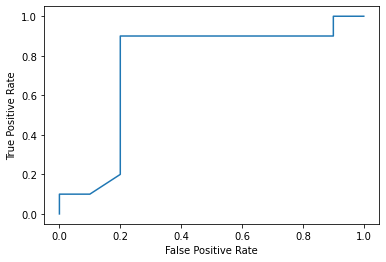

The ROC AUC is:  0.755
The optimal cutoff for the probability is:  0.004202965633399439
The Accuracy is:  0.8


In [26]:
model_A_cutoff = evaluate_predictions(predict_proba_bn(model_A, validation_set, model_A_nodes, "Class/ASD"), validation_set["Class/ASD"].values)

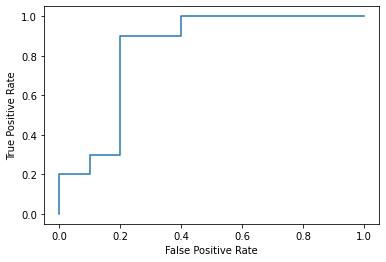

The ROC AUC is:  0.8300000000000001
The optimal cutoff for the probability is:  0.2173030653389672
The Accuracy is:  0.8


In [27]:
model_B_cutoff = evaluate_predictions(predict_proba_bn(model_B, validation_set, model_B_nodes, "Class/ASD"), validation_set["Class/ASD"].values)

## Algorithmically Learning the Structure

  0%|                                                                          | 35/1000000 [00:03<26:28:01, 10.49it/s]


Edges:  [('A2_Score', 'A6_Score'), ('A2_Score', 'Used_App_Before'), ('A6_Score', 'Class/ASD'), ('A6_Score', 'Relation'), ('A3_Score', 'A5_Score'), ('A3_Score', 'A7_Score'), ('A3_Score', 'Ethnicity'), ('A3_Score', 'A1_Score'), ('A3_Score', 'A10_Score'), ('A3_Score', 'A4_Score'), ('A5_Score', 'Autism'), ('A5_Score', 'A4_Score'), ('A5_Score', 'A7_Score'), ('A5_Score', 'A2_Score'), ('A7_Score', 'A1_Score'), ('A7_Score', 'Autism'), ('A10_Score', 'A2_Score'), ('A10_Score', 'Autism'), ('A10_Score', 'Class/ASD'), ('A4_Score', 'A6_Score'), ('A4_Score', 'A10_Score'), ('A4_Score', 'A8_Score'), ('A4_Score', 'A7_Score'), ('A4_Score', 'Jaundice'), ('A4_Score', 'Class/ASD'), ('Class/ASD', 'Ethnicity'), ('A9_Score', 'A3_Score'), ('A9_Score', 'A4_Score'), ('A9_Score', 'A2_Score'), ('A9_Score', 'A6_Score'), ('A9_Score', 'Class/ASD'), ('A9_Score', 'A5_Score'), ('A9_Score', 'A8_Score'), ('A9_Score', 'A10_Score'), ('A9_Score', 'A1_Score')]



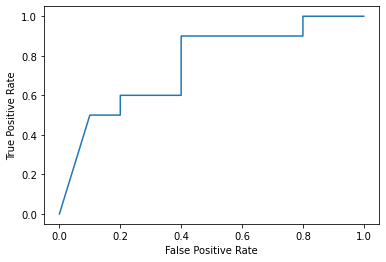

The ROC AUC is:  0.7550000000000001
The optimal cutoff for the probability is:  0.13272813445152432
The Accuracy is:  0.65


In [28]:
hc = HillClimbSearch(train_set)
hc_model = BayesianNetwork(hc.estimate(scoring_method=BDeuScore(train_set)).edges())
hc_model.fit(data=train_set[list(hc_model.nodes)], 
             estimator=BayesianEstimator,
             prior_type="BDeu",
             equivalent_sample_size=10)

print("Edges: ", hc_model.edges(), end="\n\n")

hc_model_cutoff = evaluate_predictions(predict_proba_bn(hc_model, validation_set, list(hc_model.nodes), "Class/ASD"), validation_set["Class/ASD"].values)

Working for n conditional variables: 5: 100%|████████████████████████████████████████████| 5/5 [00:35<00:00,  7.03s/it]


Undirected edges:  [('A2_Score', 'A10_Score'), ('A2_Score', 'Ethnicity'), ('A3_Score', 'A9_Score'), ('A3_Score', 'A10_Score'), ('A3_Score', 'Ethnicity'), ('A4_Score', 'A5_Score'), ('A4_Score', 'A7_Score'), ('A4_Score', 'A10_Score'), ('A5_Score', 'A7_Score'), ('A6_Score', 'Ethnicity'), ('A6_Score', 'Class/ASD'), ('A7_Score', 'Autism'), ('A9_Score', 'A10_Score'), ('A9_Score', 'Ethnicity'), ('Ethnicity', 'Relation')]

DAG edges: 
 [('A5_Score', 'A4_Score'), ('A5_Score', 'A7_Score'), ('A4_Score', 'A10_Score'), ('Autism', 'A7_Score'), ('A7_Score', 'A4_Score'), ('A10_Score', 'A3_Score'), ('A3_Score', 'A9_Score'), ('A3_Score', 'Ethnicity'), ('Relation', 'Ethnicity'), ('Class/ASD', 'A6_Score')]



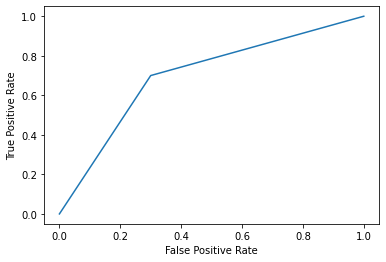

The ROC AUC is:  0.7
The optimal cutoff for the probability is:  0.523109243697479
The Accuracy is:  0.5


In [29]:
pc = PC(train_set)
skeleton, seperating_sets = pc.build_skeleton()
print("Undirected edges: ", skeleton.edges(), end="\n\n")

dag = pc.skeleton_to_pdag(skeleton, seperating_sets).to_dag()
print("DAG edges: \n", dag.edges(), end="\n\n")

pc_model = BayesianNetwork(dag.edges())
pc_model.fit(data=train_set[list(pc_model.nodes)], 
             estimator=BayesianEstimator,
             prior_type="BDeu",
             equivalent_sample_size=10)

pc_model_cutoff = evaluate_predictions(predict_proba_bn(pc_model, validation_set, list(pc_model.nodes), "Class/ASD"), validation_set["Class/ASD"].values)

  0%|                                                                          | 30/1000000 [00:02<27:37:59, 10.05it/s]


Edges:  [('A2_Score', 'A9_Score'), ('A2_Score', 'A4_Score'), ('A2_Score', 'A10_Score'), ('A2_Score', 'A3_Score'), ('A2_Score', 'Used_App_Before'), ('A9_Score', 'A3_Score'), ('A9_Score', 'A4_Score'), ('A9_Score', 'A10_Score'), ('A9_Score', 'A6_Score'), ('A9_Score', 'A8_Score'), ('A9_Score', 'A7_Score'), ('A4_Score', 'A10_Score'), ('A4_Score', 'A6_Score'), ('A4_Score', 'A5_Score'), ('A4_Score', 'A8_Score'), ('A10_Score', 'A3_Score'), ('A10_Score', 'A1_Score'), ('A10_Score', 'A6_Score'), ('A3_Score', 'Ethnicity'), ('A3_Score', 'A5_Score'), ('A3_Score', 'A7_Score'), ('A3_Score', 'A1_Score'), ('A5_Score', 'A7_Score'), ('A7_Score', 'A1_Score'), ('A6_Score', 'Relation'), ('Age', 'Class/ASD'), ('Class/ASD', 'A1_Score'), ('Class/ASD', 'A5_Score'), ('Class/ASD', 'A8_Score'), ('Class/ASD', 'A2_Score'), ('Class/ASD', 'A6_Score'), ('Class/ASD', 'A7_Score'), ('Class/ASD', 'A10_Score'), ('Class/ASD', 'A4_Score'), ('Class/ASD', 'A3_Score'), ('Class/ASD', 'A9_Score'), ('Class/ASD', 'Ethnicity'), ('Jaun

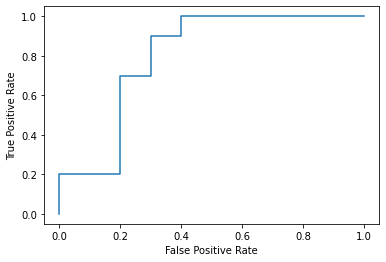

The ROC AUC is:  0.8
The optimal cutoff for the probability is:  0.09078457989977107
The Accuracy is:  0.75


In [ ]:
hc_mixed_model = BayesianNetwork(hc.estimate(scoring_method=BDeuScore(train_set), fixed_edges=model_B_edges).edges())
hc_mixed_model.fit(data=train_set[list(hc_mixed_model.nodes)], 
                   estimator=BayesianEstimator,
                   prior_type="BDeu",
                   equivalent_sample_size=10)

print("Edges: ", hc_mixed_model.edges(), end="\n\n")

hc_mixed_model_cutoff = evaluate_predictions(predict_proba_bn(hc_mixed_model, validation_set, list(hc_mixed_model.nodes), "Class/ASD"), validation_set["Class/ASD"].values)

# Testing on the private test set

In [ ]:
test_set = pd.read_csv(TEST_SET_PATH)
ids = test_set['ID'].values

test_set.rename(columns = {'age':'Age', 'gender': 'Gender', 'ethnicity': 'Ethnicity', 'jaundice': 'Jaundice', 'austim':'Autism', 
                            'contry_of_res': 'Country_of_Res', 'used_app_before': 'Used_App_Before', 'result': 'Result', 'age_desc': 'Age_Desc', 'relation': 'Relation'}, inplace = True)
test_set["Relation"] = test_set["Relation"].str.replace("?", "Unknown", regex=False)
test_set['Jaundice'] = test_set['Jaundice'].map(no_yes_map)
test_set['Autism'] = test_set['Autism'].map(no_yes_map)
test_set['Relation'] = test_set['Relation'].map(relation_map)
test_set['Age'] = pd.cut(test_set['Age'], bins=age_bins, labels=age_labels, right=False)
test_set['Age'] = test_set['Age'].map(age_map).astype(int)
test_set['Used_App_Before'] = test_set['Used_App_Before'].map(no_yes_map)
test_set["Ethnicity"] = test_set["Ethnicity"].str.replace("?", "Unknown", regex=False).replace("others", "Others", regex=False).map(ethnicity_map).astype(int)

test_set.drop(labels=["Gender", "Age_Desc", "ID", "Result", "Country_of_Res"], axis=1, inplace=True)

In [ ]:
probs_model_A = predict_proba_bn(model_A, test_set, list(set(model_A_nodes) - {"Class/ASD"}), "Class/ASD")
y_pred_model_A = (probs_model_A > model_A_cutoff) * 1
submission_model_A = pd.DataFrame.from_dict({'ID': ids, 'Class/ASD': y_pred_model_A})
submission_model_A.to_csv('submission_model_A.csv', index=None)

probs_model_B = predict_proba_bn(model_B, test_set, list(set(model_B_nodes) - {"Class/ASD"}), "Class/ASD")
y_pred_model_B = (probs_model_B > model_B_cutoff) * 1
submission_model_B = pd.DataFrame.from_dict({'ID': ids, 'Class/ASD': y_pred_model_B})
submission_model_B.to_csv('submission_model_B.csv', index=None)

probs_hc_model = predict_proba_bn(hc_model, test_set, list(set(hc_model.nodes) - {"Class/ASD"}), "Class/ASD")
y_pred_hc_model = (probs_hc_model > hc_model_cutoff) * 1
submission_hc_model = pd.DataFrame.from_dict({'ID': ids, 'Class/ASD': y_pred_hc_model})
submission_hc_model.to_csv('submission_model_hc_model.csv', index=None)

probs_hc_mixed_model = predict_proba_bn(hc_mixed_model, test_set, list(set(hc_mixed_model.nodes) - {"Class/ASD"}), "Class/ASD")
y_pred_hc_mixed_model = (probs_hc_mixed_model > hc_mixed_model_cutoff) * 1
submission_hc_mixed_model = pd.DataFrame.from_dict({'ID': ids, 'Class/ASD': y_pred_hc_mixed_model})
submission_hc_mixed_model.to_csv('submission_hc_mixed_model.csv', index=None)

probs_pc_model = predict_proba_bn(pc_model, test_set, list(set(pc_model.nodes) - {"Class/ASD"}), "Class/ASD")
y_pred_pc_model = (probs_pc_model > pc_model_cutoff) * 1
submission_pc_model = pd.DataFrame.from_dict({'ID': ids, 'Class/ASD': y_pred_pc_model})
submission_pc_model.to_csv('submission_pc_model.csv', index=None)

* HC Model: 0.71326
* HC Mixed Model: 0.63440
* PC Model: 0.79211
* Model A: 0.72043
* Model B: 0.72939